# Phonon Calculation

## This script will show how to use mdapy to calculate phonon dispersion.

### One should install Phonopy by one of the following ways:

- pip install phonopy
- conda install -c conda-forge phonopy

In [1]:
# import necessary package

import mdapy as mp
mp.init()

[Taichi] version 1.7.2, llvm 15.0.1, commit 0131dce9, win, python 3.10.14
[Taichi] Starting on arch=x64


In [2]:
print('mdapy version is :', mp.__version__)

mdapy version is : 0.11.4


## We use graphene as an example.

In [3]:
# Build a graphene

lat = mp.LatticeMaker(1.42, 'GRA', 1, 1, 1)
lat.compute()

# Add a vacuum layer with 0.2 nm along z direction.
lat.box[2, 2] += 20

# Generate a system

system = mp.System(pos=lat.pos, box=lat.box)

The key step in calculating phonon is obtaining force set from finite displacements.
So we need to provide a potential to compute the atomic forces. In mdapy, we originally support 
NEP and eam/alloy potential. Besides, we also provide a interface to call lammps to computer force, where 
one need to install lammps-python interface. Further more, user can define a custom potential for whatever you like, and we will discuss latter.

## NEP potential

This NEP potential is downloaded from [here](https://github.com/brucefan1983/GPUMD/blob/master/potentials/nep).

In [4]:
potential = mp.NEP('../../../example/C_2024_NEP4.txt')

In [5]:
potential.info

{'version': 4,
 'zbl': False,
 'radial_cutoff': 7.0,
 'angular_cutoff': 4.0,
 'n_max_radial': 12,
 'n_max_angular': 8,
 'basis_size_radial': 16,
 'basis_size_angular': 12,
 'l_max_3body': 4,
 'num_node': 67,
 'num_para': 7239,
 'element_list': ['C']}

To plot band structure, one need also provide the band path and labels.

One can obtain those by [seekpath](https://www.materialscloud.org/work/tools/seekpath) online.

In [6]:
# For graphene
path = '0.0 0.0 0.0 0.3333333333 0.3333333333 0.0 0.5 0.0 0.0 0.0 0.0 0.0'
labels = '$\Gamma$ K M $\Gamma$'

In [7]:
# Relax system

relax = system.minimize(['C'], potential, volume_change=True, hydrostatic_strain=True)

Energy minimization with volume change started.
Step 0: Pe = -31.810223 eV, f_max = 0.051110 eV/A, pressure = 0.133599 GPa.
Step 20: Pe = -31.810610 eV, f_max = 0.007024 eV/A, pressure = -0.000143 GPa.
Step 40: Pe = -31.810610 eV, f_max = 0.000294 eV/A, pressure = -0.000009 GPa.
Step 58: Pe = -31.810610 eV, f_max = 0.000010 eV/A, pressure = 0.000000 GPa.
Energy minimization with volume change finished.


In [8]:
# Do computation
relax.cal_phono_dispersion(path, labels, potential, elements_list=['C'])

Then one can plot the band stucture.

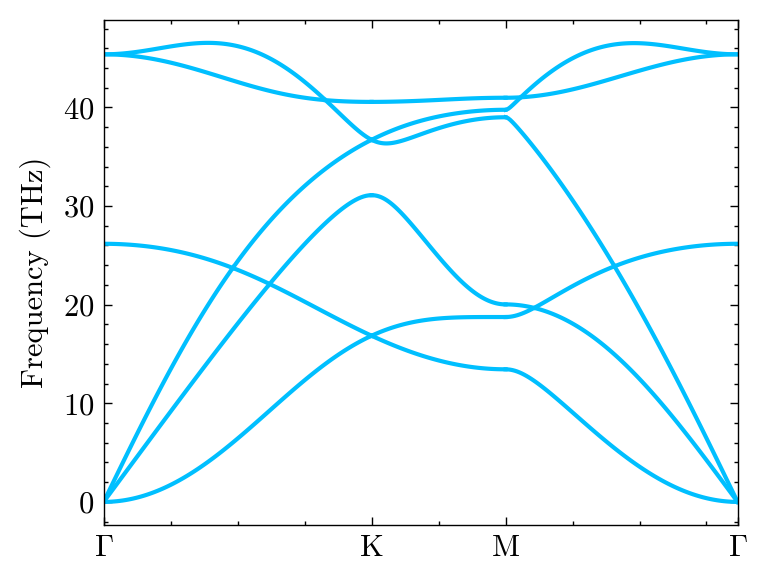

In [9]:
fig, ax, _ = relax.Phon.plot_dispersion()

One can custom the figure detail.

(0.0, 50.0)

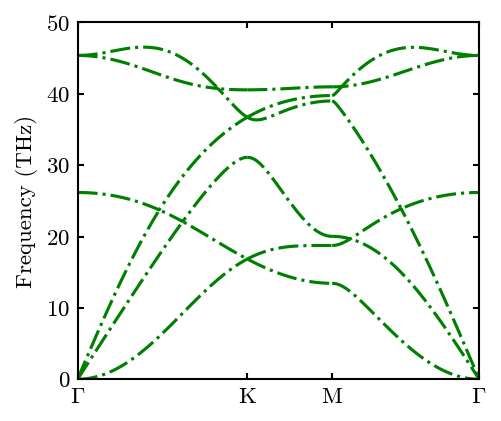

In [10]:
# all parameters can be found in plt.rcParams
mp.pltset(**{"xtick.major.width":1., 
             "ytick.major.width":1., 
             "axes.linewidth":1., 
             'xtick.minor.visible':False, 
             'ytick.minor.visible':False,
             })
fig, ax = mp.set_figure(figsize=(8, 8), figdpi=150)
fig, ax, _ = relax.Phon.plot_dispersion(fig, ax, c='green', linestyle='-.')
ax.set_ylim(0, 50)

We can compare it with the DFT results.

(0.0, 50.0)

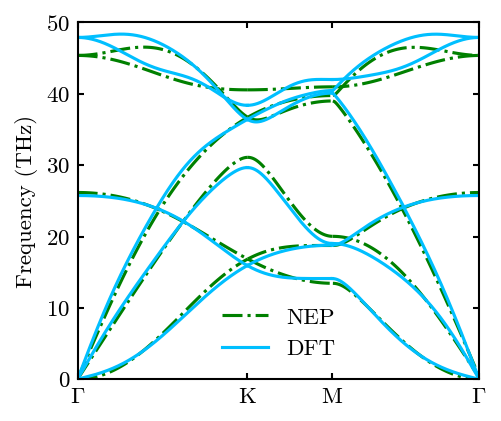

In [11]:
fig, ax = mp.set_figure(figsize=(8, 8), figdpi=150)
fig, ax, line1 = relax.Phon.plot_dispersion(fig, ax, c='green', linestyle='-.')

fig, ax, line2 = relax.Phon.plot_dispersion(fig, ax, filename='../../../example/gra.dat')

ax.legend([line1, line2], ['NEP', 'DFT'])
ax.set_ylim(0, 50)

One can check the data.

In [13]:
relax.Phon.bands_dict.keys()

dict_keys(['qpoints', 'distances', 'frequencies', 'eigenvectors', 'group_velocities'])

One can also compute the dos, pdos and thermal properties.

## Computer dos

In [14]:
relax.Phon.compute_dos(mesh=(30, 30, 30))

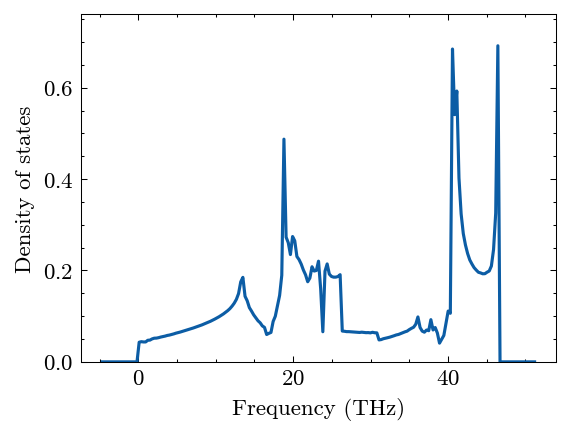

In [15]:
fig, ax = relax.Phon.plot_dos()

## Compute pdos

In [16]:
relax.Phon.compute_pdos(mesh=(30, 30, 30))

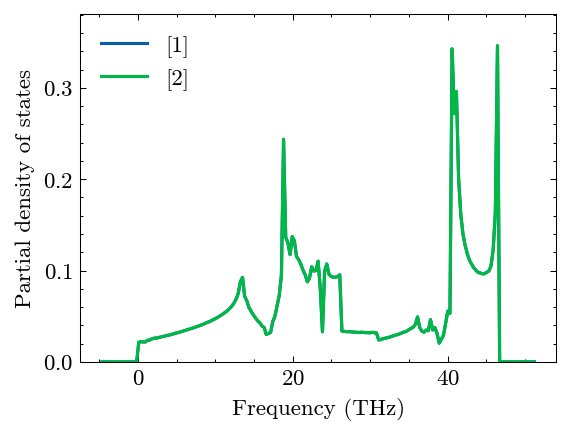

In [17]:
fig, ax = relax.Phon.plot_pdos()

## Compute thermal properties

In [18]:
relax.Phon.compute_thermal(0, 50, 1000, mesh=(30, 30, 30))

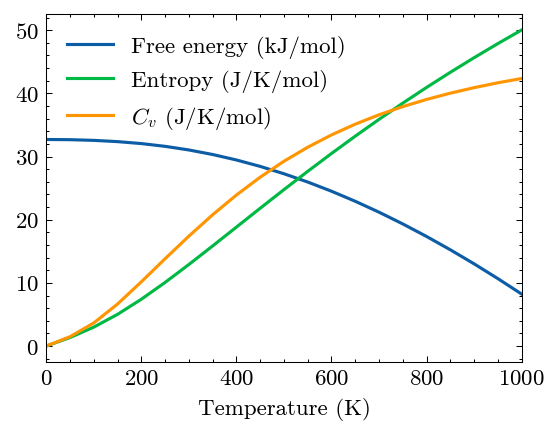

In [19]:
fig, ax = relax.Phon.plot_thermal()

## Airebo potential

Here we show how to use a lammps potential to calculate the phonon.
How to install lammps-python interface can be found in [here](https://docs.lammps.org/Python_install.html).
You can check it by:
- from lammps import lammps

In [20]:
from mdapy.potential import LammpsPotential

One need to provide the pair_parameter in lammps format.

The airebo potential is downloaded from lammps example folder.

In [21]:
potential = LammpsPotential(
    """
    pair_style airebo 3.0
    pair_coeff * * ../../../example/CH.airebo C
    """
)

In [22]:
# Do computation
system.cal_phono_dispersion(path, labels, potential, elements_list=['C'])

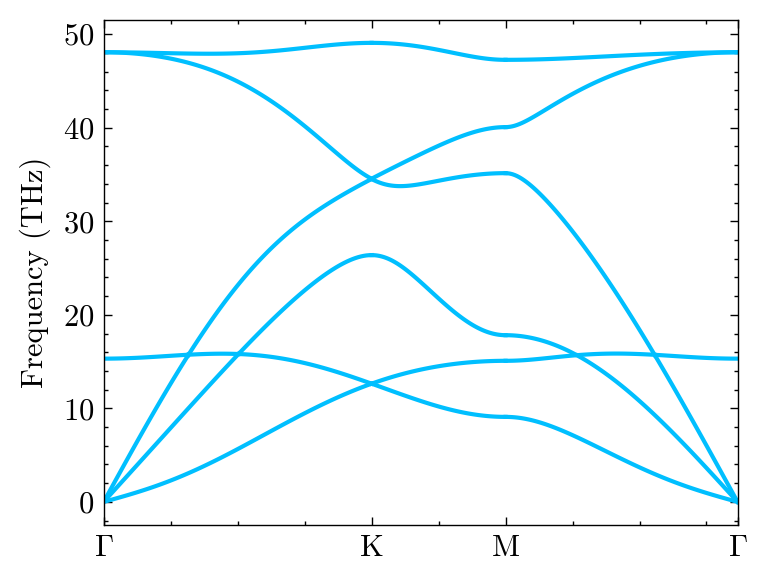

In [23]:
fig, ax, _ = system.Phon.plot_dispersion()

Some potential maybe need other setup and the units, such as reaxFF, we need to change the force units.

## ReaxFF potential

This reaxff potential is downloaded from [here](https://www.ctcms.nist.gov/potentials/entry/2022--Fthenakis-Z-G-Petsalakis-I-D-Tozzini-V-Lathiotakis-N-N--C-H-O-N/).

In [24]:
potential = LammpsPotential(
    """
    pair_style	reaxff ../../../example/lmp_control
    pair_coeff	* * ../../../example/ffield.reax.GR-RDX-2021 Cg
    """,
    atomic_style='charge',
    units='real',
    extra_args='fix 1 all qeq/reax 1 0.0 10.0 1e-6 reaxff',
    conversion_factor={'energy':0, 'force':1/23.06, 'virial':0}
)

# here we do not care energy and virial, only need to converse force from
# kcal/mol/A to eV/A

In [25]:
# Do computation
system.cal_phono_dispersion(path, labels, potential, elements_list=['C'])

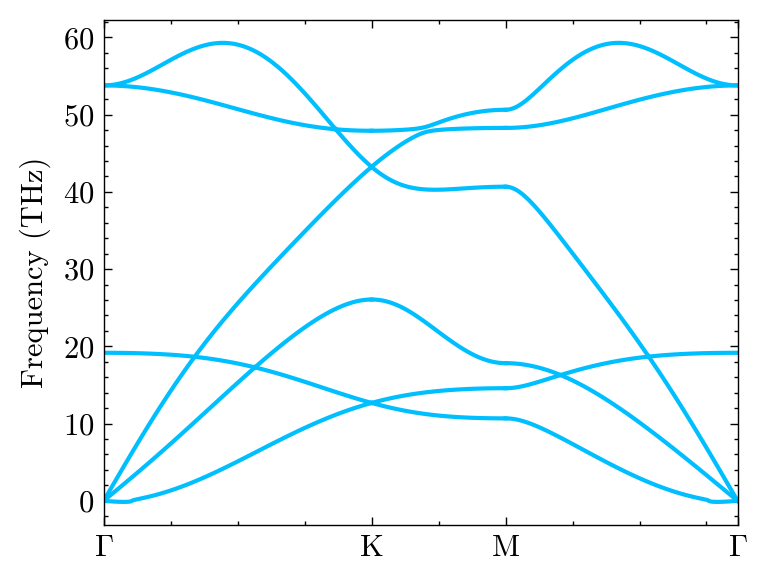

In [26]:
fig, ax, _ = system.Phon.plot_dispersion()

Sometimes we want to use other potential not supported by lammps, we can define it for mdapy very easily. Here we use deepmd potential as an example.

# User-defined potential

In [27]:
from mdapy.potential import BasePotential

One can install deepmd by:

- pip install deepmd-kit[cpu]

In [28]:
import deepmd

Instructions for updating:
non-resource variables are not supported in the long term


In [29]:
deepmd.__version__

'2.2.10'

In [30]:
from deepmd.infer import DeepPot

In [31]:
class DP(BasePotential):

    def __init__(self, filename):
        self.filename = filename
        self.dp = DeepPot(self.filename)

    def compute(self, pos, box, elements_list, type_list, boundary=[1, 1, 1],):
        # This method must containe the above input parameter and keep the same order.
        # You can add other parameter if needed, and those parameter dose not need to be all used.
        # This method should return three parameters and the second is force array. The shape is (Natom, 3).
        # The units should be eV/A.

        coord = pos.reshape([1, -1])
        cell = box[:-1].reshape([1, -1])
        atype = type_list-1
        e, f, v = self.dp.eval(coord, cell, atype)
        return e, f[0], v

This deepmd potential downloaded from [this paper](https://doi.org/10.1016/j.carbon.2021.09.062). We convert it to new version:

- dp convert-from -i .\carbon_16689_frozen_model_mmc1.pb -o carbon.pb

In [32]:
potential = DP("../../../example/carbon.pb")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [33]:
# Do computation
system.cal_phono_dispersion(path, labels, potential, elements_list=['C'])

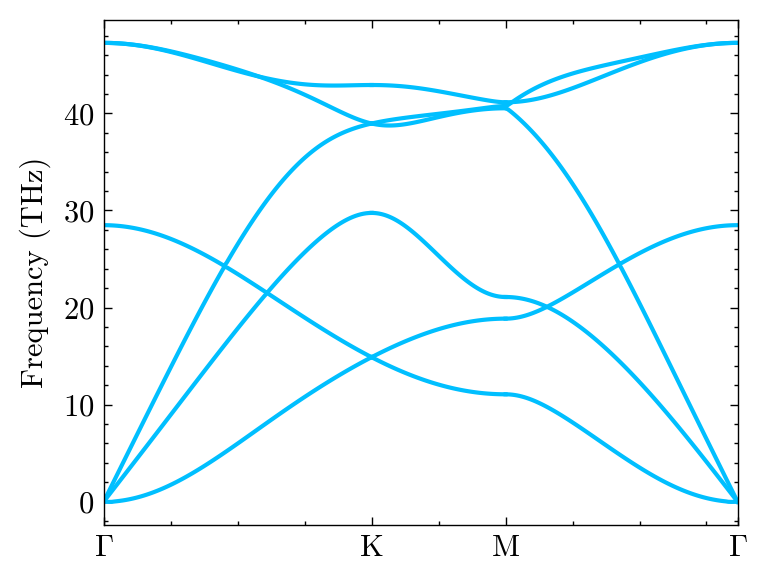

In [34]:
fig, ax, _ = system.Phon.plot_dispersion()